ENTENDIMIENTO DEL PROBLEMA

Objetivo: predecir la cantidad de unidades vendidas en los próximos 30 días.

Tipo de problema: regresión sobre series temporales.

Impacto de negocio: planificación de stock, logística y compras.

Modelo elegido: Prophet

In [246]:
import pandas as pd

In [247]:
df = pd.read_csv("/content/sales_train.csv")

**EDA:**

In [248]:
print(df.shape)
print(df.info())
print(df.describe())

(2935849, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700

**En cuanto a la variable objetivo**:

Valores atípicos:

Mínimo: -22 (¡devoluciones?).

Máximo: 2,169 (posible outlier).

Distribución:

Media: 1.24, Mediana: 1 → Asimetría positiva (muchas ventas bajas y pocas muy altas).

Desviación estándar: 2.62 → Indica dispersión moderada.

El 75% de los datos estan por debajo de 1

In [249]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [250]:
print(df['item_id'].nunique()) #Contamos con 21,807 productos diferentes. Podríamos analizar/predicir cuáles tendrán mayor movimiento de ventas en los próximos 30 días.

21807


(-10.0, 100.0)

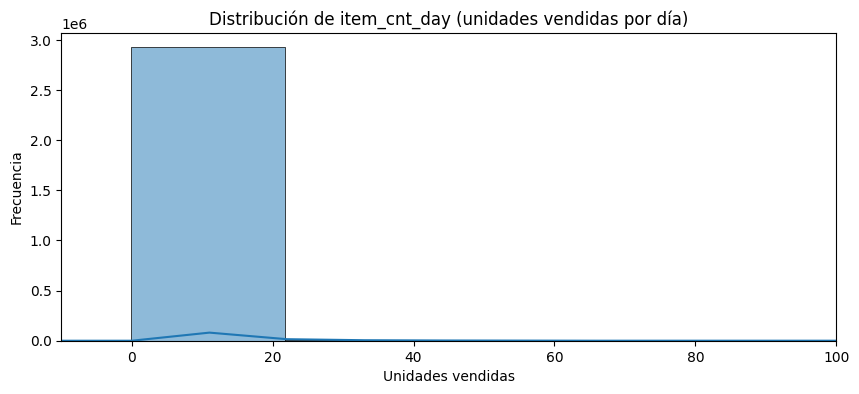

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt #matplotlib.pyplot: Interfaz estilo MATLAB (la más usada para gráficos rápidos)

#Graficamos un histograma, para ver la distribución de la variable objetivo
plt.figure(figsize=(10, 4))
sns.histplot(df['item_cnt_day'], bins=100, kde=True)
plt.title('Distribución de item_cnt_day (unidades vendidas por día)')
plt.xlabel('Unidades vendidas')
plt.ylabel('Frecuencia')
plt.xlim(-10, 100)  #Recortamos los datos para visualizarlos mejor (hay muchos valores extremos grandes)

Tenemos un pico gigante entre 0 y 20. Significa que la mayoría de los registros son ventas de pocas unidades. El resto del gráfico da la sensación de estar vacío, porque hay valores muy grandes (outliers) que estiran el eje X hasta 100 o más. Podemos achicar más el eje -->

(-10.0, 30.0)

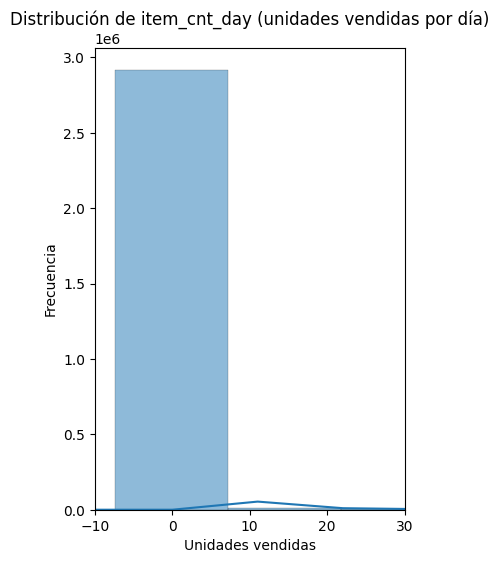

In [252]:
plt.figure(figsize= (4,6))
sns.histplot(df["item_cnt_day"], bins = 150 , kde = True)
plt.title("Distribución de item_cnt_day (unidades vendidas por día)")
plt.xlabel("Unidades vendidas")
plt.ylabel("Frecuencia")
plt.xlim(-10,30)

es interesante analizar los valores negativos:

In [253]:
print(df[df['item_cnt_day'] < 0].head(15))

print("Valores negativos:", len(df[df['item_cnt_day'] < 0]))
print("Porcentaje:", len(df[df['item_cnt_day'] < 0])/len(df)*100, "%")

            date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2     05.01.2013               0       25     2552      899.00          -1.0
148   23.01.2013               0       25     2321      999.00          -1.0
175   07.01.2013               0       25     2199     1449.00          -1.0
807   02.01.2013               0       25     2330      599.00          -1.0
1041  13.01.2013               0       25     5034     1989.00          -1.0
1193  02.01.2013               0       25     5651     5490.00          -1.0
1674  07.01.2013               0       25     4093      899.00          -1.0
1825  02.01.2013               0       25     4249     1894.87          -1.0
2411  14.01.2013               0       24     1628     3899.00          -1.0
3216  08.01.2013               0       24    20948      899.00          -1.0
3386  20.01.2013               0       24    11756      169.00          -1.0
3447  20.01.2013               0       24     9547      149.00          -1.0

Todos los ejemplos muestran: -1.0 en item_cnt_day, fechas concentradas en enero 2013, mismo shop_id (25) en los ejemplos. Por lo que la principal causa puede ser devoluciones.

In [254]:
df["item_cnt_day"] = df["item_cnt_day"].clip(lower=0)

En la formula anterior suponiendo que los negativos son devoluciones, osea no implican ventas futuras, si no un valor 0. Remplazamos los valores negativos por un valor de venta futura = 0

(0.0, 10.0)

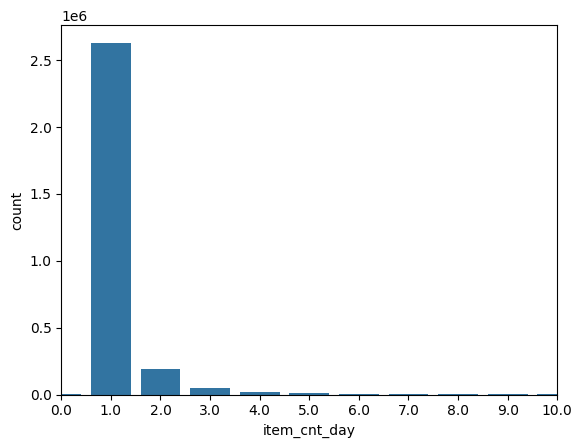

In [255]:

sns.countplot(x='item_cnt_day', data=df)
plt.xlim(0, 10)

El 99% de los valores está entre 0 y 5. El pico más alto está cerca de las 5 unidades vendidas por día. El eje Y muestra que hay casi 3 millones de registros con ventas bajas.

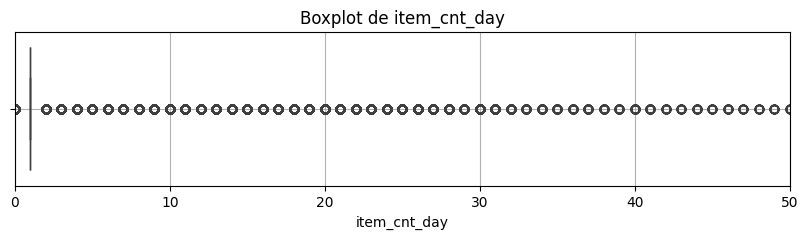

In [256]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['item_cnt_day'])
plt.title("Boxplot de item_cnt_day")
plt.xlim(0,50)
plt.grid(True)
plt.show()

Caja a la izquierda: representa los valores "normales", aproximadamente entre 0 y ~5 unidades vendidas.

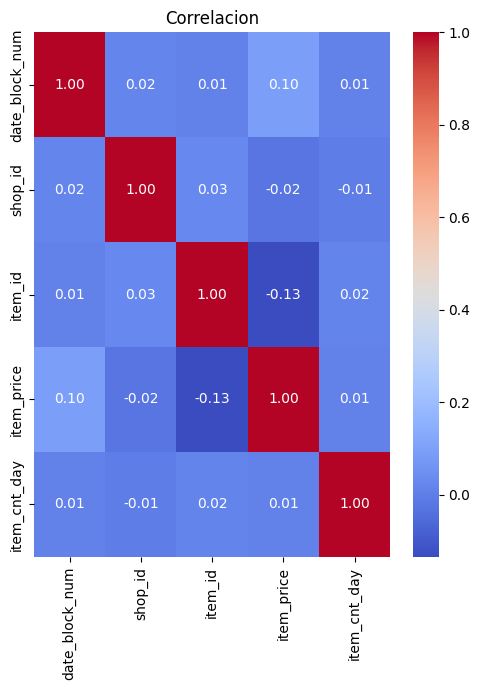

In [257]:
num_cols = df.select_dtypes(include = "number")
corr_matrix = num_cols.corr()

plt.figure(figsize = (5,7))
sns.heatmap(corr_matrix , annot=True , cmap='coolwarm', fmt=".2f" )
plt.title("Correlacion")
plt.tight_layout()
plt.show()

In [258]:
print(corr_matrix["item_cnt_day"].sort_values(ascending = False))


item_cnt_day      1.000000
item_id           0.016474
item_price        0.011521
date_block_num    0.009412
shop_id          -0.005281
Name: item_cnt_day, dtype: float64


No se ve una correlación marcada, son todos valores bajos.

Asimetria

In [259]:
print("\nAsimetría:\n", num_cols.skew())


Asimetría:
 date_block_num      0.203858
shop_id            -0.072361
item_id             0.257174
item_price         10.750423
item_cnt_day      273.391710
dtype: float64


item_price (10.75) y item_cnt_day (272.83) tienen asimetría extrema positiva: esto sugiere que hay valores atípicos (outliers) muy altos o una distribución muy concentrada en valores bajos con colas largas hacia la derecha.

In [260]:
print("\nCurtosis:\n", num_cols.kurt())


Curtosis:
 date_block_num        -1.082869
shop_id               -1.025358
item_id               -1.225210
item_price           445.532826
item_cnt_day      177962.675309
dtype: float64


item_price (445.53) y item_cnt_day (177478.09) tienen curtosis extremadamente alta: esto indica colas muy pesadas y picos pronunciados, confirmando la presencia de outliers o distribuciones muy alejadas de lo normal.

**Data_Wrangling**

Vemos nulos

In [261]:
df.isnull().sum() / len(df) * 100 #vemos que no tenemos nulos

,0
date,0.0
date_block_num,0.0
shop_id,0.0
item_id,0.0
item_price,0.0
item_cnt_day,0.0


Vemos duplicados


In [262]:
 df[df.duplicated()] #vemos que los duplicados no corresponden a la misma fecha, por ende son distintos.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


Vemos Outliers

<Axes: xlabel='item_cnt_day'>

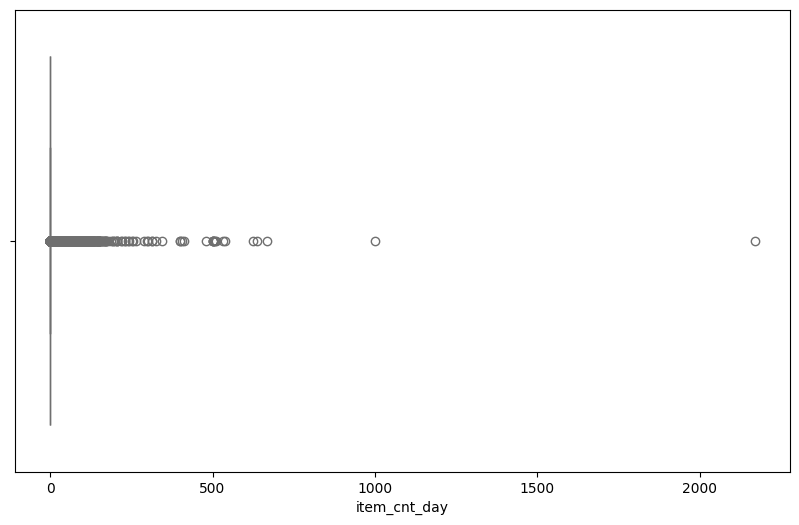

In [263]:
#Calculamos outliers con IQR, ya que esta es mas robusta y no asume normalidad
Q1_cnt = df["item_cnt_day"].quantile(0.25)
Q3_cnt = df["item_cnt_day"].quantile(0.75)
IQR_cnt = Q3_cnt - Q1_cnt
upper_limit_cnt = Q3_cnt + 1.5 * IQR_cnt  # Límite superior


plt.figure(figsize=(10, 6))
sns.boxplot(x=df["item_cnt_day"], color="skyblue")


Vemos que no es util usar IQR, debido a que q1,q2 y q3 tienen el mismo valor. Usamos entonces percentiles:

 NO es necesario eliminar outliers con Z-score ni IQR "clásico" para Prophet.

Enconces podemos aplicar: Capar (clip) los valores extremos en lugar de eliminarlos. Usamos asi el quantile 0,999. El 99.9% de los datos son menores o iguales a este valor. Eliminamos asi aquellos outliers extremos:

In [264]:
# Aplicamos el percentil:limite_superior = df["item_cnt_day"].quantile(0.999)
df["item_cnt_day"] = df["item_cnt_day"].clip(upper=limite_superior)

In [265]:
print(df['item_cnt_day'].value_counts().sort_index(ascending=False).head(30))

item_cnt_day
22.0       3124
21.0        290
20.0        364
19.0        347
18.0        391
17.0        438
16.0        544
15.0        638
14.0        716
13.0        918
12.0       1083
11.0       1263
10.0       1820
9.0        2177
8.0        2903
7.0        4057
6.0        6338
5.0       10474
4.0       19685
3.0       47350
2.0      194201
1.0     2629372
0.0        7356
Name: count, dtype: int64


La distribución está algo sesgada a la izquierda, pero ya no es extrema. Y aún hay colas largas, pero ya no es patológica como antes (>100.000). Prophet lo puede manejar.

Feature engineering:  Agrupamos los datos por fecha diaria, es decir sumamos todas las ventas transformadas (ya procesadas) por cada día del dataset.

In [268]:
df_daily = df.groupby("date").agg({"item_cnt_day": "sum"}).reset_index()
df_daily.columns = ["ds", "y"]

In [269]:
df_daily

,ds,y
0,01.01.2013,1953.0
1,01.01.2014,2283.0
2,01.01.2015,2087.0
3,01.02.2013,3828.0
4,01.02.2014,5669.0
...,...,...
1029,31.10.2013,3808.0
1030,31.10.2014,3014.0
1031,31.10.2015,3105.0
1032,31.12.2013,10312.0


Dividir en entrenamiento y test: No se puede usar train_test_split porque romperías la secuencia temporal. Por ello, usámos los últimos 30 días como test, y el resto como entrenamiento:

In [270]:
df_daily["ds"] = pd.to_datetime(df_daily["ds"], dayfirst=True)

In [271]:
df_daily = df_daily.sort_values("ds")
train = df_daily[:-30] #todo el histórico menos los últimos 30 días.
test = df_daily[-30:] #solo los últimos 30 días → para evaluar si el modelo puede predecir el futuro.

Entrenar Prophet

In [272]:
from prophet import Prophet
model = Prophet()
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxfgycsg/i7b2r5fv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnxfgycsg/51f7pkz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45338', 'data', 'file=/tmp/tmpnxfgycsg/i7b2r5fv.json', 'init=/tmp/tmpnxfgycsg/51f7pkz0.json', 'output', 'file=/tmp/tmpnxfgycsg/prophet_modele5oi0ic3/prophet_model-20250624201233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predecir ventas futuras: Ahora que aprendio el patrón de ventas con train, quiero generar las fechas futuras en las que quiero que el modelo me diga qué va a pasar." Las crea a partir de la ultima fecha de train, ya que prophet sabe automáticamente cuál es la última fecha que vio durante el entrenamiento (model.fit(train)), porque el modelo guarda esa información internamente.

In [273]:
future = model.make_future_dataframe(periods=30) #agrega 30 fechas después de la última del train”

Genero la prediccion ahora: Prophet usa lo que aprendió en el entrenamiento (fit) y predice el valor de la variable objetivo (y) para cada fecha de future, incluyendo las futuras(osea las fechas creadas en el paso anterior):

In [274]:
forecast = model.predict(future)

In [275]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,4449.105780,5770.682037,7960.037279,4449.105780,4449.105780,2445.856805,2445.856805,2445.856805,-550.348872,-550.348872,-550.348872,2996.205677,2996.205677,2996.205677,0.0,0.0,0.0,6894.962585
1,2013-01-02,4448.040802,5624.955859,7776.604474,4448.040802,4448.040802,2222.320316,2222.320316,2222.320316,-586.670757,-586.670757,-586.670757,2808.991073,2808.991073,2808.991073,0.0,0.0,0.0,6670.361119
2,2013-01-03,4446.975825,5576.633218,7663.558913,4446.975825,4446.975825,2153.241360,2153.241360,2153.241360,-444.772100,-444.772100,-444.772100,2598.013460,2598.013460,2598.013460,0.0,0.0,0.0,6600.217184
3,2013-01-04,4445.910847,5980.952415,8111.689015,4445.910847,4445.910847,2584.614720,2584.614720,2584.614720,217.966818,217.966818,217.966818,2366.647902,2366.647902,2366.647902,0.0,0.0,0.0,7030.525567
4,2013-01-05,4444.845869,6940.540092,9134.947677,4444.845869,4444.845869,3579.457862,3579.457862,3579.457862,1460.876529,1460.876529,1460.876529,2118.581332,2118.581332,2118.581332,0.0,0.0,0.0,8024.303731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,2015-10-27,2166.621176,137.539616,2279.728553,2165.642980,2167.729492,-1004.274954,-1004.274954,-1004.274954,-550.348872,-550.348872,-550.348872,-453.926082,-453.926082,-453.926082,0.0,0.0,0.0,1162.346222
1030,2015-10-28,2163.144829,177.965261,2196.654476,2162.025802,2164.338905,-1015.618838,-1015.618838,-1015.618838,-586.670757,-586.670757,-586.670757,-428.948081,-428.948081,-428.948081,0.0,0.0,0.0,1147.525991
1031,2015-10-29,2159.668482,221.003802,2355.032925,2158.455411,2160.949222,-836.286567,-836.286567,-836.286567,-444.772100,-444.772100,-444.772100,-391.514467,-391.514467,-391.514467,0.0,0.0,0.0,1323.381915
1032,2015-10-30,2156.192134,998.639620,3115.844852,2154.872074,2157.595007,-124.284470,-124.284470,-124.284470,217.966818,217.966818,217.966818,-342.251288,-342.251288,-342.251288,0.0,0.0,0.0,2031.907664


yhat es la variable que me interesa, sería la predicción de Prophet

Unimos el data set de test con el de forecast para comparar las predicciones:

In [277]:
resultados = forecast[["ds", "yhat"]].merge(test, on="ds", how="inner")
resultados

,ds,yhat,y
0,2015-10-02,2883.338870,3096.0
1,2015-10-03,4144.512232,4561.0
2,2015-10-04,3343.994090,4006.0
3,2015-10-05,1949.308416,1347.0
4,2015-10-06,2138.955592,1331.0
5,2015-10-07,2086.476169,1900.0
6,2015-10-08,2202.896739,1566.0
7,2015-10-09,2831.011202,1923.0
8,2015-10-10,4030.567385,2732.0
9,2015-10-11,3168.112602,2458.0


Evaluamos los resultados:

In [278]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(resultados["y"], resultados["yhat"])
rmse = np.sqrt(mean_squared_error(resultados["y"], resultados["yhat"]))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 431.59848929529727
RMSE: 520.1902804594165


Veamos que obtenimos:

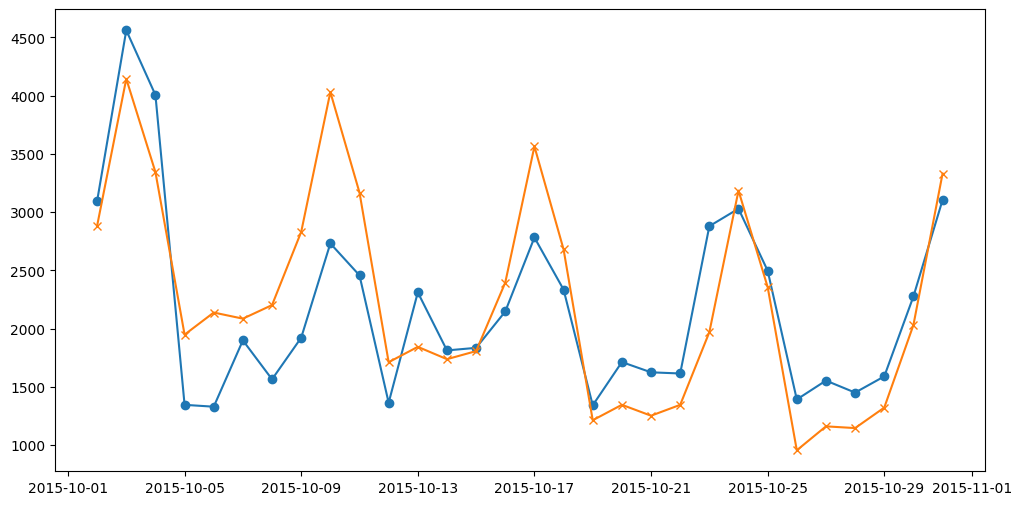

In [279]:
plt.figure(figsize=(12, 6))
plt.plot(resultados["ds"], resultados["y"], label="Real", marker='o')
plt.plot(resultados["ds"], resultados["yhat"], label="Predicción", marker='x')

Podemos ver varias cosas:


*   El modelo Prophet sigue bien la forma general de las ventas: capta los ciclos semanales (subidas y bajadas).
*   Hay ciertos días con sobreestimación o subestimación, lo cual es normal sin regresores extra (como feriados, clima, precios, etc.).

